# The Smith Parasite - An Unknown Parasitic Disease
## Who is more likely to suffer from the Smith Parasite?

# Imports

In [1]:
# general
import os
import math
import functools
import itertools

import pandas               as pd
import numpy                as np
import seaborn              as sns
import matplotlib.pyplot    as plt
import scipy.stats          as stats

# preprocessing
from sklearn.model_selection    import train_test_split
from sklearn.model_selection    import StratifiedKFold
from sklearn.model_selection    import learning_curve
from sklearn.model_selection    import RandomizedSearchCV
from sklearn.preprocessing      import OneHotEncoder
from sklearn.preprocessing      import StandardScaler
from sklearn.preprocessing      import MinMaxScaler
from sklearn.preprocessing      import RobustScaler
from sklearn.decomposition      import PCA
from sklearn.feature_selection  import RFECV
from sklearn.feature_selection  import SelectFromModel
from sklearn.inspection         import permutation_importance
from sklearn.pipeline           import Pipeline
from sklearn.compose            import ColumnTransformer

# classifier
from sklearn.linear_model       import LogisticRegression
from sklearn.linear_model       import SGDClassifier
from sklearn.svm                import SVC
from sklearn.neural_network     import MLPClassifier
from sklearn.tree               import DecisionTreeClassifier
from sklearn.ensemble           import RandomForestClassifier

# metrics
from sklearn.metrics            import f1_score
from sklearn.model_selection    import cross_val_score
from sklearn.metrics            import RocCurveDisplay
from sklearn.metrics            import PrecisionRecallDisplay

---
# Load Data

In [2]:
# create dictionary with filename:data as key:value pairs
data = {dataset_name.replace('.xlsx', ''): pd.read_excel(f'Data/{dataset_name}') for dataset_name in os.listdir('Data') if 'xlsx' in dataset_name}

# merge train datasets on PatientID
data_frames = [data['train_demo'], data['train_habits'], data['train_health']]
df = functools.reduce(lambda  left,right: pd.merge(left,right,on=['PatientID'], how='outer'), data_frames).set_index('PatientID')

# merge test datasets on PatientID
data_frames = [data['test_demo'], data['test_habits'], data['test_health']]
df_test = functools.reduce(lambda  left,right: pd.merge(left,right,on=['PatientID'], how='outer'), data_frames).set_index('PatientID')

---
# Exploratory Data Analysis

In [3]:
# first look on the data
df.sample(5)

,Name,Birth_Year,Region,Education,Disease,Smoking_Habit,Drinking_Habit,Exercise,Fruit_Habit,Water_Habit,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Checkup,Diabetes
PatientID,,,,,,,,,,,,,,,,,,
1843,Mr. Richard Howard,1963,Yorkshire and the Humber,Elementary School (1st to 9th grade),0,No,I consider myself a social drinker,No,Less than 1. I do not consume fruits every day.,More than half a liter but less than one liter,162,70,277,160,12,0,More than 3 years,"I don't have diabetes, but I have direct famil..."
1263,Mrs. Norma Fernandez,1967,East of England,Elementary School (1st to 9th grade),1,No,I usually consume alcohol every day,No,Less than 1. I do not consume fruits every day.,More than half a liter but less than one liter,158,64,346,132,21,5,More than 3 years,I do have diabetes
1328,Mr. Kelly Ogorman,1952,South West,University Complete (3 or more years),0,No,I consider myself a social drinker,No,5 to 6 pieces of fruit in average,More than half a liter but less than one liter,178,72,326,130,8,11,More than 3 years,Neither I nor my immediate family have diabetes.
1119,Mr. Ronald Ledezma,1980,South East,University Incomplete (1 to 2 years),1,No,I usually consume alcohol every day,No,Less than 1. I do not consume fruits every day.,Between one liter and two liters,162,78,299,120,20,0,More than 3 years,I do have diabetes
1948,Mr. Victor Hugill,1952,Yorkshire and the Humber,High School Graduate,0,No,I usually consume alcohol every day,Yes,Less than 1. I do not consume fruits every day.,Less than half a liter,174,55,178,145,12,12,Not sure,Neither I nor my immediate family have diabetes.


In [4]:
# list datatypes
df.dtypes

Name                object
Birth_Year           int64
Region              object
Education           object
Disease              int64
Smoking_Habit       object
Drinking_Habit      object
Exercise            object
Fruit_Habit         object
Water_Habit         object
Height               int64
Weight               int64
High_Cholesterol     int64
Blood_Pressure       int64
Mental_Health        int64
Physical_Health      int64
Checkup             object
Diabetes            object
dtype: object

In [5]:
# check for missing values and empty strings
pd.concat([df.isnull().sum(),df.eq('').sum()],keys=['Nulls','Empty Strings'],axis=1)

,Nulls,Empty Strings
Name,0,0
Birth_Year,0,0
Region,0,0
Education,13,0
Disease,0,0
Smoking_Habit,0,0
Drinking_Habit,0,0
Exercise,0,0
Fruit_Habit,0,0
Water_Habit,0,0


In [6]:
# check for duplicated rows
df.duplicated().sum()

0

In [7]:
# descriptive statistics
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Name,800,799,Mr. Gary Miller,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Birth_Year,800.0,NaN,NaN,NaN,1966.04375,15.421872,1855.0,1961.0,1966.0,1974.0,1993.0
Region,800,10,East Midlands,154,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education,787,6,University Complete (3 or more years),239,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Disease,800.0,NaN,NaN,NaN,0.51375,0.500124,0.0,0.0,1.0,1.0,1.0
Smoking_Habit,800,2,No,673,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Drinking_Habit,800,3,I usually consume alcohol every day,406,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Exercise,800,2,No,536,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fruit_Habit,800,5,Less than 1. I do not consume fruits every day.,452,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Water_Habit,800,3,Between one liter and two liters,364,NaN,NaN,NaN,NaN,NaN,NaN,NaN


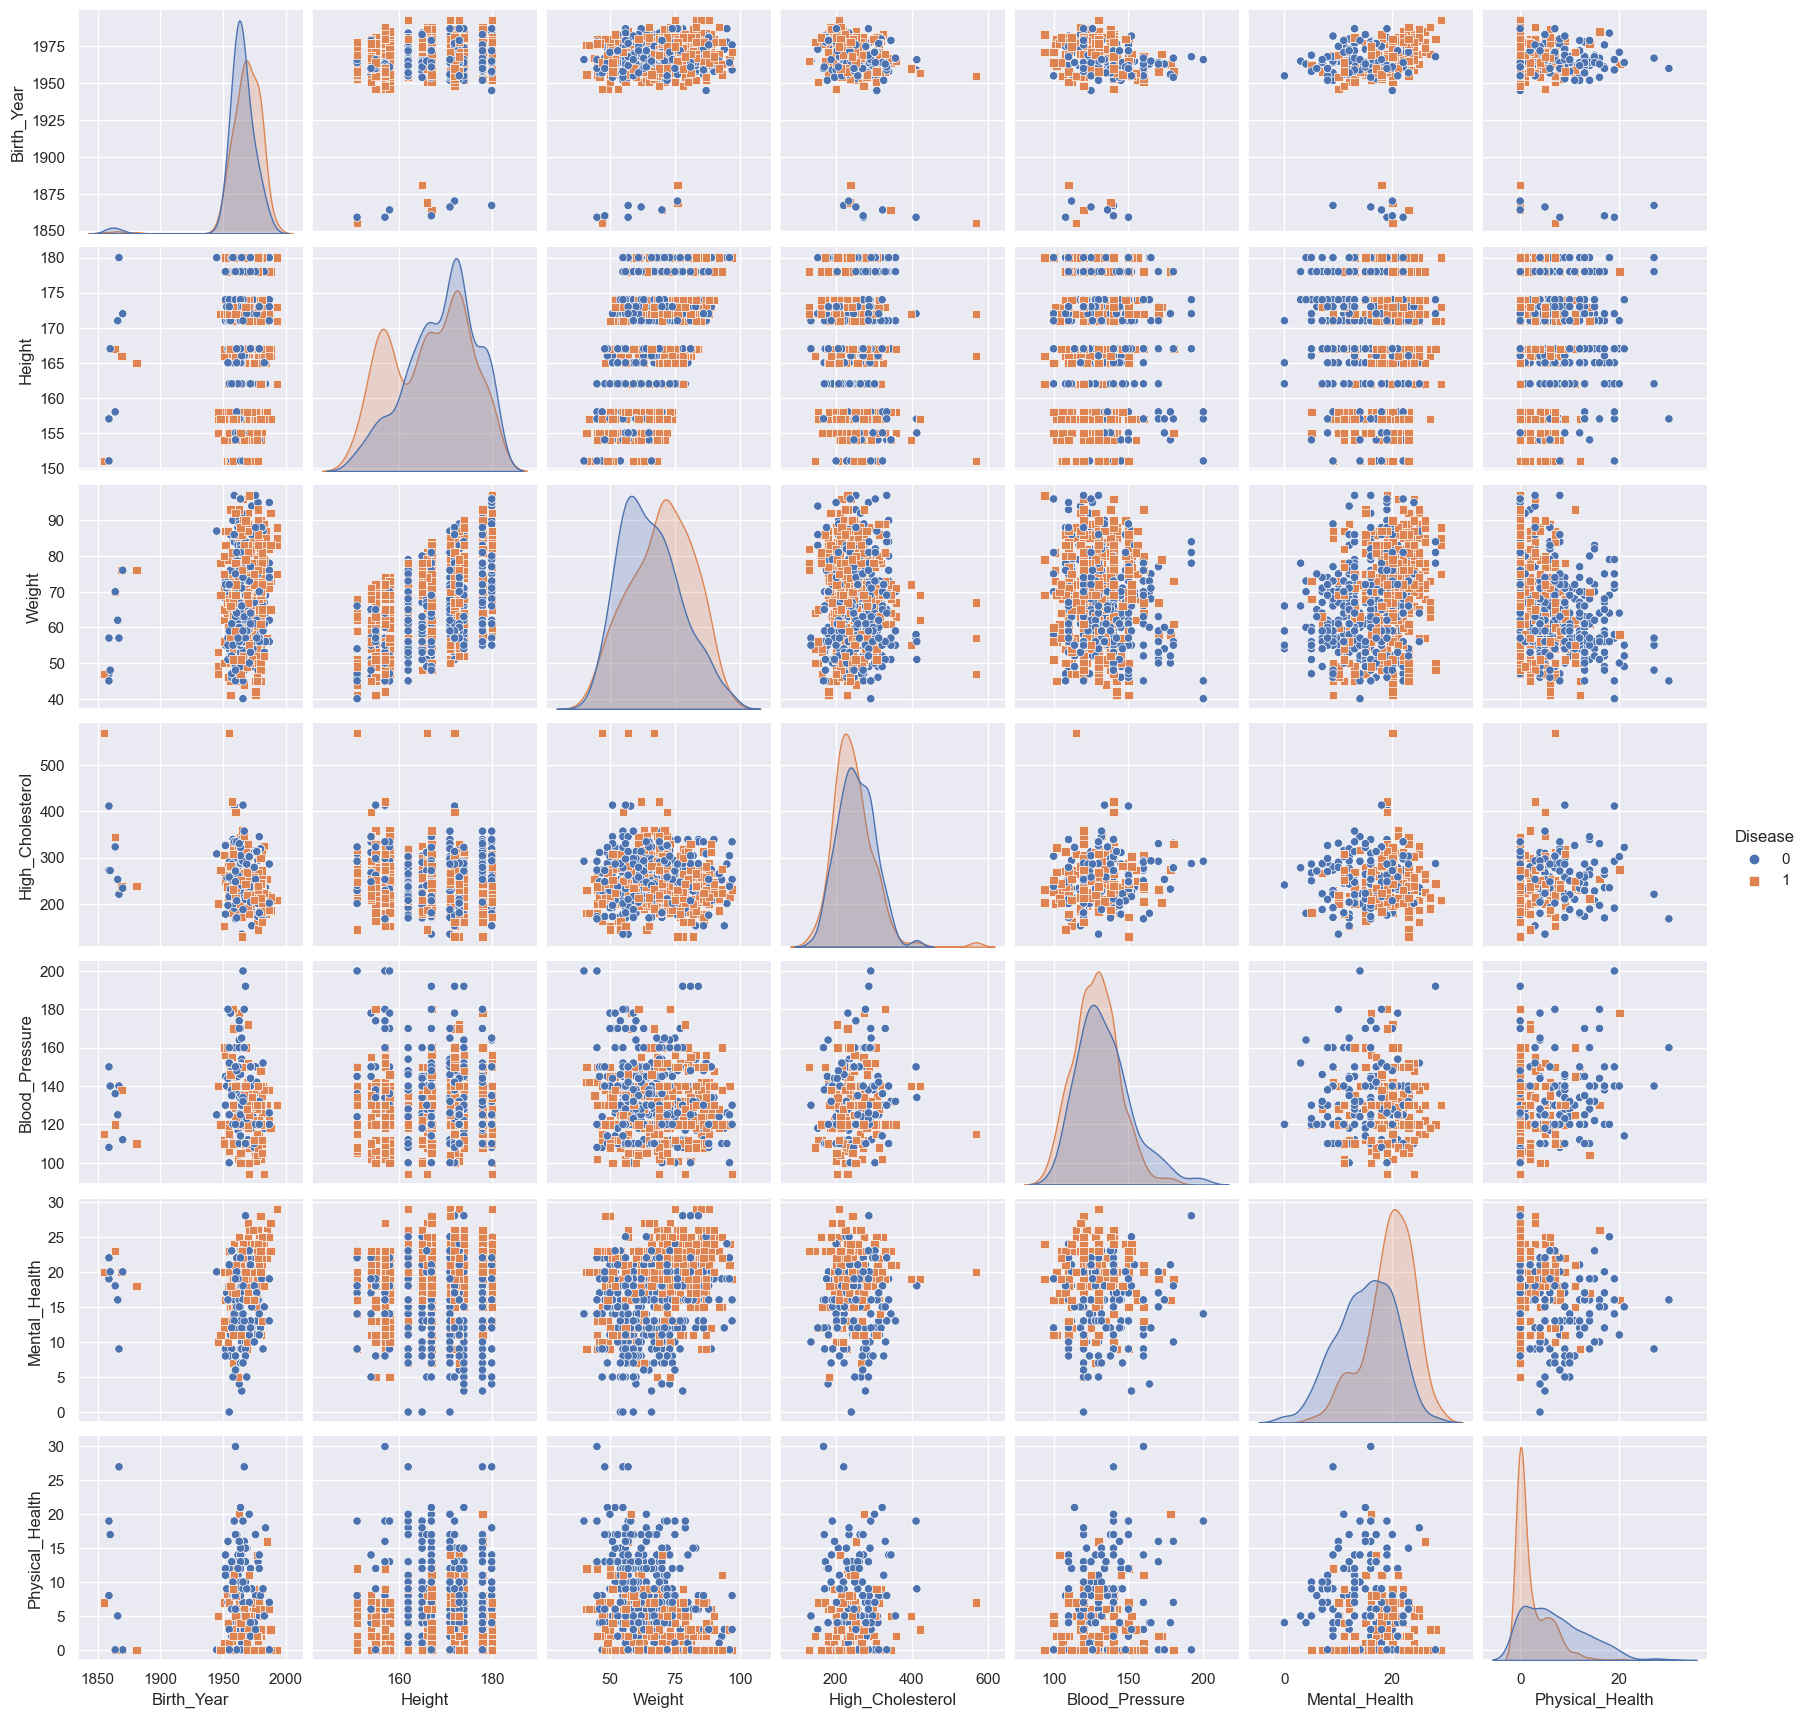

In [8]:
sns.set()

# plot pairwise relationships and densities
sns.pairplot(df, hue = 'Disease', markers = ['o', 's'])
plt.show()

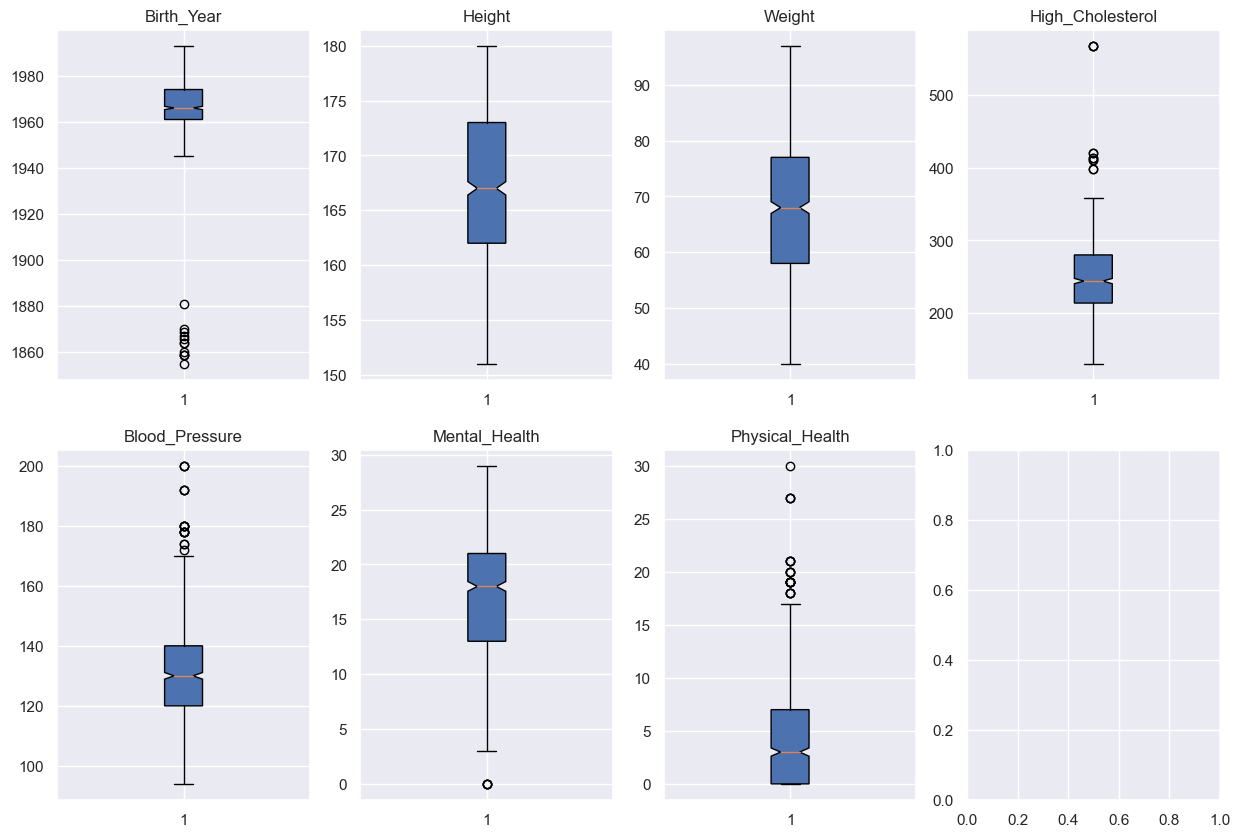

In [9]:
# select numeric features (exclude target array)
df_numeric_features = list(df.select_dtypes(include = np.number).columns)
df_numeric_features.remove('Disease')

# boxplot of numeric features
fig, ax = plt.subplots(math.ceil(len(df_numeric_features)/4),4, figsize = (15,10))
for ax, feat in zip(ax.flatten(), df_numeric_features):
    ax.boxplot(df[feat], notch = True, patch_artist = True)
    ax.set_title(feat)

plt.show()

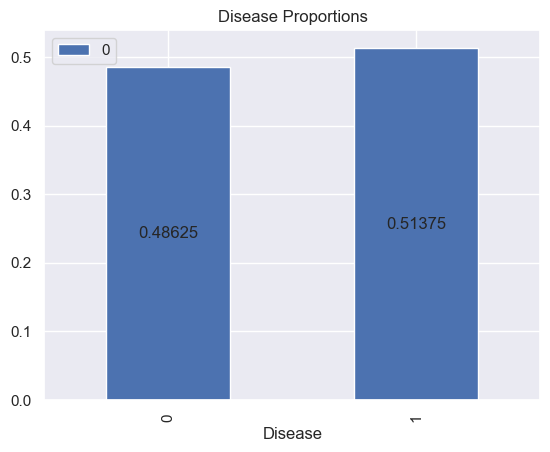

In [10]:
#Disease Distribution
ddf=df.copy()

dis=pd.DataFrame((ddf.groupby("Disease").size()/ddf.shape[0]))
ax = dis.plot(kind='bar', stacked=False, title='Disease Proportions')

for container in ax.containers:
    ax.bar_label(container, label_type='center')

plt.show()


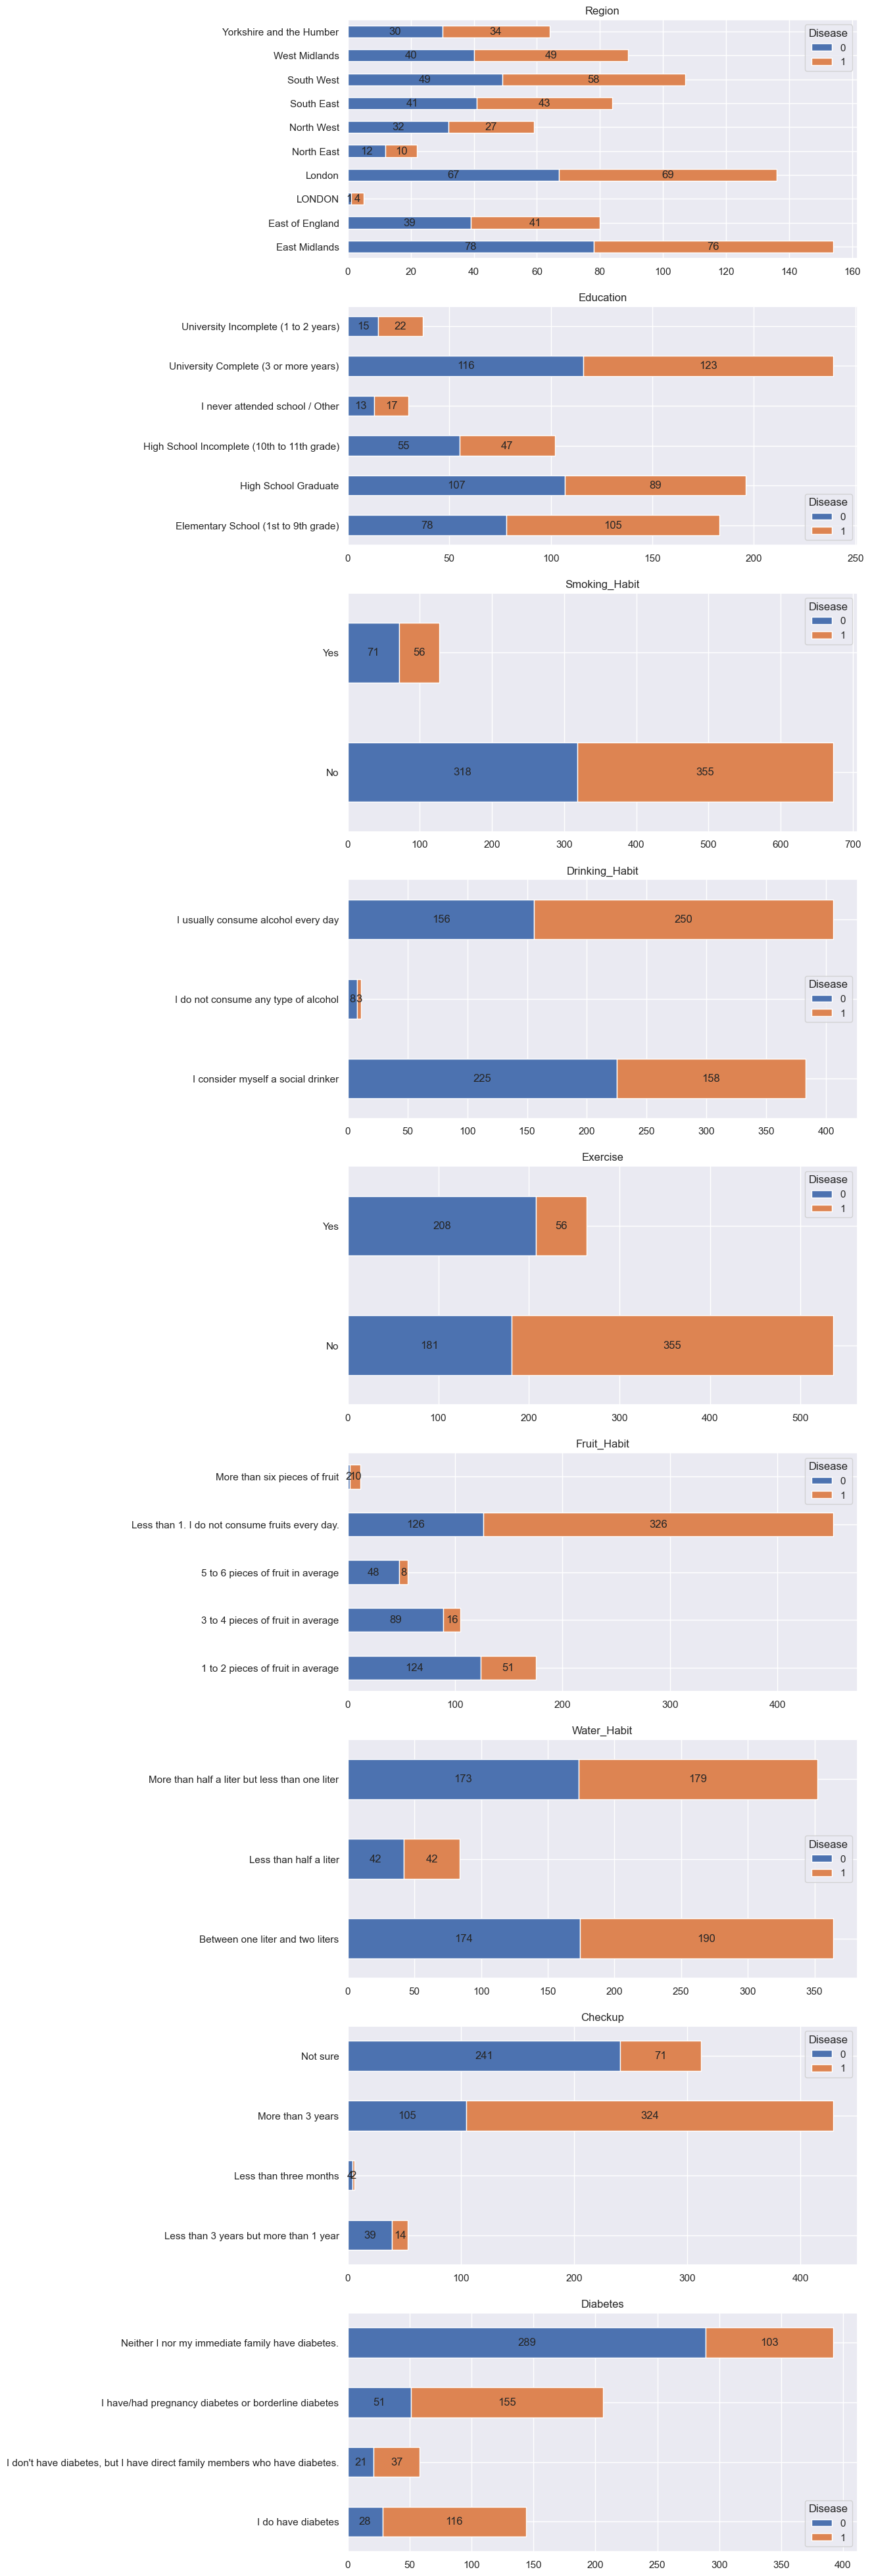

In [11]:
# select categorical features (exclude name column)
df_categorical_features = list(df.select_dtypes(exclude = np.number).columns)
df_categorical_features.remove('Name')

# stacked barplot of categorical features (with regard to target value)
fig, ax = plt.subplots(len(df_categorical_features), figsize = (10,50))
for ax, feat in zip(ax.flatten(), df_categorical_features):
    pivot_tbl = df[[feat, 'Disease']].pivot_table(index = feat, columns = ['Disease'],  aggfunc=len)
    graph = pivot_tbl.plot(kind='barh', stacked=True, title=feat, ax=ax)
    ax.set_ylabel('')
    for c in ax.containers:
        ax.bar_label(c, label_type='center')

plt.show()

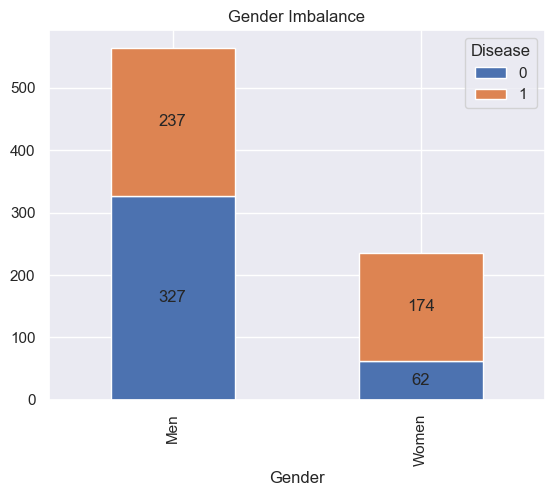

In [12]:
# plot gender distribution
gender_imbalance = df.copy()
gender_imbalance['Gender'] = ['Men' if i.split(' ')[0] == 'Mr.' else 'Women' for i in gender_imbalance.Name]
pivot_tbl = gender_imbalance[['Gender', 'Disease']].pivot_table(index = 'Gender', columns = ['Disease'],  aggfunc=len)

ax = pivot_tbl.plot(kind='bar', stacked=True, title='Gender Imbalance')

for container in ax.containers:
    ax.bar_label(container, label_type='center')

plt.show()

---
# Baseline Model
- Stochastic Gradient Descent with only numeric values
- We are building a baseline model to get an idea of the predictability of our data and to get a first comparabale value for the evaluation of our preprocessing

In [13]:
# split to data & target
x, y = df.drop(columns = ['Disease']), df['Disease']

In [14]:
# select numeric features
initial_xnumeric = x.select_dtypes(include = np.number)
xnumeric_cols = list(initial_xnumeric.columns)

# stratified train-test split
xtrain, xval, ytrain, yval = train_test_split(initial_xnumeric, y, random_state = 0 ,test_size = 0.2, shuffle = True , stratify = y)

In [15]:
# very basic baseline model
model = SGDClassifier(random_state = 1)
model.fit(xtrain,ytrain)

ypred = model.predict(xval)

baseline_f1 = f1_score(yval, ypred)

print(f'F1 score: {baseline_f1}')

F1 score: 0.6776859504132231


---
# Preprocessing
- To ensure traceability and consistency we are using a function for our preprocessing
- The exact steps are described below:

In [16]:
def preprocessing(dataframe):

    # fix Birth_Year errors. here we assume that the outliers are typos
    # the numbers 8 & 9 are pretty close to each other on a keyboard. therefore we add 100 to every year that's smaller than 1900
    # (e.g. 1869 --> 1969)
    dataframe['Birth_Year'] = [i + 100 if i < 1900 else i for i in dataframe['Birth_Year']]

    # add Age column
    dataframe['Age'] = [2022 - i for i in dataframe['Birth_Year']]
    xnumeric_cols.append('Age')

    # add Gender column (1: Male, 0: Female)
    # afterwards drop column Name
    dataframe['Gender']  = [1 if i.split(' ')[0] == 'Mr.' else 0 for i in dataframe['Name']]
    dataframe.drop(columns = ['Name'], inplace = True)

    # add BMI columns
    dataframe['BMI'] = [i/(j/100)**2 for i, j in zip(dataframe['Weight'], dataframe['Height'])]
    dataframe['BMI_Cateogry'] = [0 if i < 18.5 else 1 if i < 25 else 2 if i < 30 else 3 if i < 35 else 4 for i in dataframe['BMI']]
    xnumeric_cols.append('BMI')

    # set all region values to lowercase
    dataframe['Region'] = [i.lower() for i in dataframe['Region']]

    # handle High_Cholesterol, Blood_Pressure, Physical_Health
    # flooring and capping outliers
    for col in ['High_Cholesterol', 'Blood_Pressure', 'Physical_Health']:
        q25, q75, iqr = dataframe[col].quantile(.25), dataframe[col].quantile(.75), dataframe[col].quantile(.75) - dataframe[col].quantile(.25)
        upper_lim = q75 + 1.5 * iqr
        lower_lim = q25 - 1.5 * iqr
        dataframe[col] = [upper_lim if i > upper_lim else lower_lim if i < lower_lim else i for i in dataframe[col]]

    # encode Smoking_Habit & Exercise to binary (1: Yes, 0: No)
    dataframe['Smoking_Habit'] = [1 if i == 'Yes' else 0 for i in dataframe['Smoking_Habit']]
    dataframe['Exercise'] = [1 if i == 'Yes' else 0 for i in dataframe['Exercise']]    
    
    # manual encoding of specific feature to don't mess up the ranking
    # all of these features have a specific ranking structure
    # another advantage is the avoidance of dimensionality increase through One-hot-encoding all categorical features

    # impute missing values in column "Education" with mode
    # encode Education
    dataframe['Education'].fillna(dataframe['Education'].mode()[0], inplace=True)
    edu_map = {
            'I never attended school / Other'               : 0,
            'Elementary School (1st to 9th grade)'          : 1,
            'High School Incomplete (10th to 11th grade)'   : 2,
            'High School Graduate'                          : 3,
            'University Incomplete (1 to 2 years)'          : 4,
            'University Complete (3 or more years)'         : 5
            }
    dataframe['Education'] = [edu_map[i] if i in edu_map.keys() else np.nan for i in dataframe['Education']]

    drink_map = {
            'I do not consume any type of alcohol'          : 0,
            'I consider myself a social drinker'            : 1,
            'I usually consume alcohol every day'           : 2
            }
    dataframe['Drinking_Habit'] = [drink_map[i] if i in drink_map.keys() else np.nan for i in dataframe['Drinking_Habit']]

    fruit_map = {
            'Less than 1. I do not consume fruits every day.'   : 0,
            '1 to 2 pieces of fruit in average'                 : 1,
            '3 to 4 pieces of fruit in average'                 : 2,
            '5 to 6 pieces of fruit in average'                 : 3,
            'More than six pieces of fruit'                     : 4
            }
    dataframe['Fruit_Habit'] = [fruit_map[i] if i in fruit_map.keys() else np.nan for i in dataframe['Fruit_Habit']]

    water_map = {
            'Less than half a liter'                            : 0,
            'More than half a liter but less than one liter'    : 1,
            'Between one liter and two liters'                  : 2
            }
    dataframe['Water_Habit'] = [water_map[i] if i in water_map.keys() else np.nan for i in dataframe['Water_Habit']]

    checkup_map = {
            'Not sure'                                          : 0,
            'More than 3 years'                                 : 1,
            'Less than 3 years but more than 1 year'            : 2,
            'Less than three months'                            : 3
            }
    dataframe['Checkup'] = [checkup_map[i] if i in checkup_map.keys() else np.nan for i in dataframe['Checkup']]

    diabetes_map = {
            'I do have diabetes'                                                            : 0,
            'I have/had pregnancy diabetes or borderline diabetes'                          : 1,
            "I don't have diabetes, but I have direct family members who have diabetes."    : 2,
            'Neither I nor my immediate family have diabetes.'                              : 3
            }
    dataframe['Diabetes'] = [diabetes_map[i] if i in diabetes_map.keys() else np.nan for i in dataframe['Diabetes']]

    return dataframe

In [17]:
# apply preprocessing steps to x
x_preprocessed = preprocessing(x.copy())

---
# Check Different Scaler Options
- Different scalers can have an impact on the used classifiers
- Therefore, we wrote a function to test different scalers against different classifiers
- The function is explained below:

In [18]:
# scaler options
scalers = [StandardScaler(), MinMaxScaler(), MinMaxScaler(feature_range = (-1,1)), RobustScaler()]

In [19]:
def test_scaler_encoder(estimator, X, y, scaler_options):
    ranking = {'scaler':[],'cv score':[]}
    for scl in scaler_options:
        
        #Seperate the numeric features from the categorical ones
        numeric_features, categorical_features = xnumeric_cols, [i for i in X.columns if not i in xnumeric_cols]
        
        #Pipeline for scaling
        numeric_transformer = Pipeline(steps=[('scaler', scl)])
        
        #Pipeline for transforming
        categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

        #Combining the transformers with the respective variables
        preprocessor = ColumnTransformer(transformers=[('cat', categorical_transformer, categorical_features),('num', numeric_transformer, numeric_features)])
        
        #Creating a pipeline for the model. This makes sure that the data is scaled 
        #Before every iteration of the k-fold cross validation
        model_pipeline = Pipeline(steps=[("preprocessor", preprocessor),("classifier", estimator)])
        
        #Finally the mean cross validation scores are generated and appendend to the dictionairy together with the  
        #name of the scaler
        ranking['scaler'].append(scl)
        ranking['cv score'].append(round(np.mean(cross_val_score(model_pipeline, X, y, cv=10, n_jobs=-1)),4))
    
    return pd.DataFrame(ranking).sort_values('cv score', ascending=False)

### Stochastic Gradient Descent Classifier

In [20]:
test_scaler_encoder(SGDClassifier(random_state=1), X=x_preprocessed, y=y, scaler_options=scalers)

,scaler,cv score
2,"MinMaxScaler(feature_range=(-1, 1))",0.8425
3,RobustScaler(),0.8387
1,MinMaxScaler(),0.8362
0,StandardScaler(),0.8188


### Support Vector Machines

In [21]:
test_scaler_encoder(SVC(random_state=1), X=x_preprocessed, y=y, scaler_options=scalers)

,scaler,cv score
0,StandardScaler(),0.9012
3,RobustScaler(),0.8975
2,"MinMaxScaler(feature_range=(-1, 1))",0.8950
1,MinMaxScaler(),0.8825


### Multilayer Perceptron

In [22]:
test_scaler_encoder(MLPClassifier(max_iter=750, random_state=1), X=x_preprocessed, y=y, scaler_options=scalers)

,scaler,cv score
2,"MinMaxScaler(feature_range=(-1, 1))",0.9038
3,RobustScaler(),0.9013
0,StandardScaler(),0.8988
1,MinMaxScaler(),0.8975


### Decision Tree

In [23]:
test_scaler_encoder(DecisionTreeClassifier(random_state=1), X=x_preprocessed, y=y, scaler_options=scalers)

,scaler,cv score
0,StandardScaler(),0.9462
1,MinMaxScaler(),0.9462
2,"MinMaxScaler(feature_range=(-1, 1))",0.9462
3,RobustScaler(),0.9462


### Random Forest

In [24]:
test_scaler_encoder(RandomForestClassifier(random_state=1), X=x_preprocessed, y=y, scaler_options=scalers)

,scaler,cv score
0,StandardScaler(),0.97
1,MinMaxScaler(),0.97
2,"MinMaxScaler(feature_range=(-1, 1))",0.97
3,RobustScaler(),0.97


---
# Train/Test Split

In [25]:
# again a stratified train-test split with the same random_state as before
xtrain, xval, ytrain, yval = train_test_split(x_preprocessed, y, random_state = 0 ,test_size = 0.2, shuffle = True , stratify = y)

---
# Prepare Train/Test Split (One-Hot-Encode, Scale) 
- We prepare the splitted dataframes for the classifiers
- In order to ensure, that the train- as well as the validation set are scaled based on the training set, we build in an if condition
- If the input "reset_fit" equals True, the function does not only scale the dataframe, but does also export the fitted scaler into a global variable (which can then be used to scale other dataframes accordingly)

In [26]:
def encode_scale(dataframe, scaler=StandardScaler(), reset_fit=False):

    '''
    One-hot-encode and scales dataframe
    If reset_fit set to TRUE encoder & scaler get refitted
    '''

    # fit_transform if no scaler and one-hot-encoder is already fitted
    if not('ohe' in globals() and 'scl' in globals()) or reset_fit == True:
        xnumeric, xcategorical = dataframe.select_dtypes(include = np.number), dataframe.select_dtypes(exclude = np.number)
        # One-hot-encoding
        # set encoder to global variable to re-use it afterwards
        global ohe
        ohe = OneHotEncoder(handle_unknown='ignore')
        categorical_encoded = pd.DataFrame(ohe.fit_transform(xcategorical).toarray(), columns = ohe.get_feature_names_out(), index = xcategorical.index)
        dataframe_encoded = pd.concat([xnumeric, categorical_encoded], axis = 1)
        # Robust-scaling
        # set scaler to global variable to re-use it afterwards
        global scl
        scl = scaler
        dataframe_scaled = pd.DataFrame(scl.fit_transform(dataframe_encoded), columns = dataframe_encoded.columns, index = dataframe_encoded.index)
        print('fit & transform successful...')
        return dataframe_scaled, dataframe_encoded

    # transform only if scaler and one-hot-encoder is already fitted
    else:
        xnumeric, xcategorical = dataframe.select_dtypes(include = np.number), dataframe.select_dtypes(exclude = np.number)
        # One-hot-encoding
        categorical_encoded = pd.DataFrame(ohe.transform(xcategorical).toarray(), columns = ohe.get_feature_names_out(), index = xcategorical.index)
        dataframe_encoded = pd.concat([xnumeric, categorical_encoded], axis = 1)
        #Robust-scaling
        dataframe_scaled = pd.DataFrame(scl.transform(dataframe_encoded), columns = dataframe_encoded.columns, index = dataframe_encoded.index)

        print('transform successful...')
        return dataframe_scaled

In [27]:
# apply encoding and scaling function on xtrain (fit & transform)
xtrain_prepro, dataframe_encoded = encode_scale(xtrain, reset_fit=True)

fit & transform successful...


In [28]:
# apply encoding and scaling function on xtrain (only transform)
xval_prepro = encode_scale(xval)

transform successful...


---
# PCA
- We tried to apply principal components to our machine learning algorithms in order to decrease dimensionality and to improve their performance
- However, since it decreased our performance we didn't inculde it in the final model

In [29]:
def principal_component_analysis(dataframe, var_treshold=0.8, reset_fit=False):
    '''
    Creates and add n principal components (dependent on variance treshold)
    '''

    # fit_transform if pca isn't already fitted
    if not 'pca' in globals() or reset_fit == True:
        # set 'pca' to global variable to re-use it afterwards
        global pca
        pca = PCA(n_components=var_treshold)
        pca_feat = pca.fit_transform(dataframe)
        pca_feat_names = [f'PC{i}' for i in range(pca.n_components_)]
        pca_df = pd.DataFrame(pca_feat, index=dataframe.index, columns=pca_feat_names)
        dataframe = pd.concat([dataframe, pca_df], axis=1)
        print('fit & transform successful...')
        return dataframe
    
    # transform only if pca is already fitted
    else:
        pca_feat = pca.transform(dataframe)
        pca_feat_names = [f'PC{i}' for i in range(pca.n_components_)]
        pca_df = pd.DataFrame(pca_feat, index=dataframe.index, columns=pca_feat_names)
        dataframe = pd.concat([dataframe, pca_df], axis=1)
        print('transform successful...')
        return dataframe

In [30]:
# add pca features to xtrain (fit & transform)
xtrain_pca = principal_component_analysis(xtrain_prepro)

fit & transform successful...


In [31]:
# add pca features to xval (only transform)
xval_pca = principal_component_analysis(xval_prepro)

transform successful...


---
# Feature Selection - Filter Methods

## Correlation Matrix (Spearman)
- Since we are dealing with a binary target variable we utilize the spearman correlation to detect any relationships between the dependent and the independent variables
- Moreover, we analyse it for redundant and noisy variables

In [32]:
# add target variable to xtrain_prepro again
df_corr = pd.merge(xtrain_prepro[xnumeric_cols], ytrain, left_index=True, right_index=True)

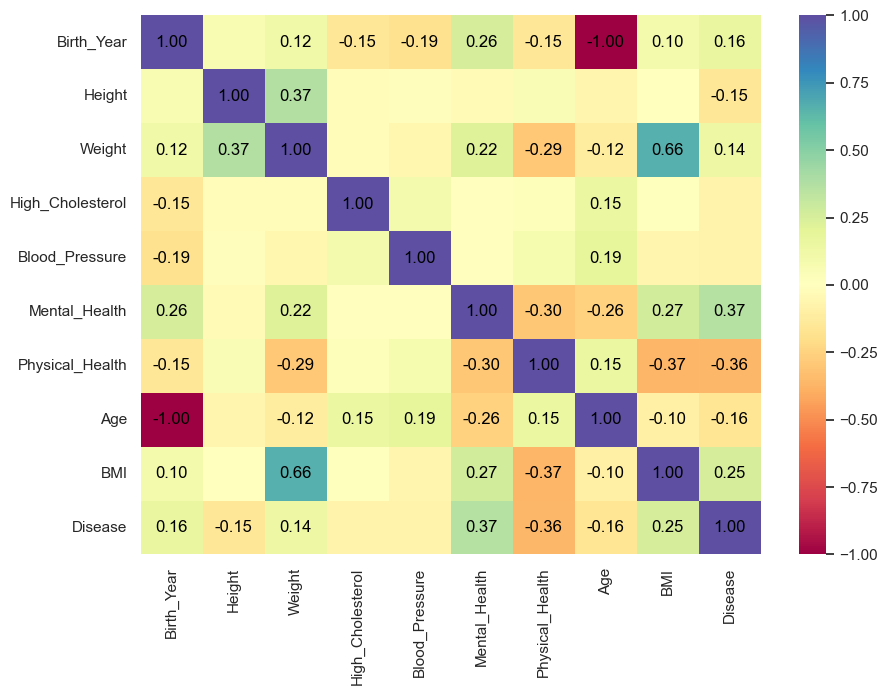

In [33]:
def heatmap(dataframe, treshold=.05):
    corr = dataframe.corr(method='kendall')
    f, ax = plt.subplots(figsize=(10,7))
    sns.heatmap(corr,cmap='Spectral',fmt='.2f')
    for i in range(len(corr)):
        for j in range(len(corr)):
            if abs(corr.iloc[i, j]) > treshold:
                ax.text(j+0.5, i+0.5, '{:.2f}'.format(corr.iloc[i, j]), 
                        ha='center', va='center', color='black')
    plt.show()

heatmap(df_corr, treshold=.099)

#Takeaways
# - Age and BirthYear are redundant
# - BMI and BMICat also redundant
# - BMI and Weight also have a very high correlation
# - Education and Water Habit are not correlated with any variable -> noise

# - Highest Correlations with the target variable: 
    # -Exercise
    # -Fruit Habit
    # -Physical Health
    # -Diabetes

## Chi-squared
- To test the importance of our categorical variables with the target variable we use the Chi-squared test

In [34]:
def TestIndependence(X,Y,var,alpha=0.05):
    CRED = '\033[91m'
    CGREEN = '\033[92m'
    CEND = '\033[0m'   
    dfObserved = pd.crosstab(Y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result= str(var) + CGREEN + ' IMPORTANT' + CEND
    else:
        result= str(var) + CRED + ' NOT IMPORTANT' + CEND
    print(result)

In [35]:
initial_xcategorical_col = [i for i in xtrain_prepro.columns if i not in xnumeric_cols]

for var in initial_xcategorical_col:
    TestIndependence(xtrain_prepro[var],ytrain, var)

Education NOT IMPORTANT
Smoking_Habit NOT IMPORTANT
Drinking_Habit IMPORTANT
Exercise IMPORTANT
Fruit_Habit IMPORTANT
Water_Habit NOT IMPORTANT
Checkup IMPORTANT
Diabetes IMPORTANT
Gender IMPORTANT
BMI_Cateogry IMPORTANT
Region_east midlands NOT IMPORTANT
Region_east of england NOT IMPORTANT
Region_london NOT IMPORTANT
Region_north east NOT IMPORTANT
Region_north west NOT IMPORTANT
Region_south east NOT IMPORTANT
Region_south west NOT IMPORTANT
Region_west midlands NOT IMPORTANT
Region_yorkshire and the humber NOT IMPORTANT


In [36]:
univariate_features = [
    # Numeric Features
    'Age',
    'Height',
    'Weight',
    'Mental_Health',
    'Physical_Health',
    'BMI',
    # Categorical Features
    'Drinking_Habit',
    'Exercise',
    'Fruit_Habit',
    'Checkup',
    'Diabetes',
    'Gender',
    'BMI_Cateogry'
]

# Feature Selection - Wrapper Methods

## Recursive Feature Elimination (RFE)
- RFE tunes a chosen model (in this case a Random Forest) with all the predictors at first
- Next we calculate the performance and the importance of the variables
- Subsequently we apply a stratified K-Fold utilizing the pipelines described earlier
- After every iteration the rankings of the predictors are calculated and only the most important ones are used for another iteration/subset
- This process of eliminating features is repeated until a desirable number of features is reached or until the performance of the model is no longer improved by removing additional features

In [37]:
pipeline = Pipeline([('transformer',StandardScaler()), ('clf',RandomForestClassifier(random_state=1))])
rfe = RFECV(pipeline, cv = 10, scoring = 'f1', n_jobs = -1, importance_getter='named_steps.clf.feature_importances_')
rfe.fit(dataframe_encoded, ytrain)
opt_features = list(rfe.get_feature_names_out(input_features = list(dataframe_encoded.columns)))
print(f'Best features: {[i for i in opt_features]}')

Best features: ['Birth_Year', 'Exercise', 'Fruit_Habit', 'Weight', 'High_Cholesterol', 'Blood_Pressure', 'Mental_Health', 'Physical_Health', 'Checkup', 'Diabetes', 'Age', 'BMI']


In [38]:
# transform data to RFE results
xtrain_rfe = rfe.transform(xtrain_prepro)
xval_rfe = rfe.transform(xval_prepro)

# Feature Selection - Embedded Method

## Select From Model
- The embedded method shows us which features are the most important while the model is being created
- The advantage of embedded methods is that they are being able to exploit the structure of the model to identify the most relevant features, which can result in improved performance compared to other methods.

In [39]:
# embedded feature selection with SelectFromModel and RandomForestClassifier
sfm = SelectFromModel(RandomForestClassifier(random_state = 1))
sfm.fit(xtrain_prepro, ytrain)

SelectFromModel(estimator=RandomForestClassifier(random_state=1))

In [40]:
# check columns
selected_feat = xtrain_prepro.columns[(sfm.get_support())]
selected_feat

Index(['Birth_Year', 'Exercise', 'Fruit_Habit', 'Weight', 'High_Cholesterol',
       'Blood_Pressure', 'Mental_Health', 'Physical_Health', 'Checkup',
       'Diabetes', 'Age', 'Gender', 'BMI'],
      dtype='object')

In [41]:
# transform data to SelectFromModel results
xtrain_sfm = pd.DataFrame(sfm.transform(xtrain_prepro), columns=xtrain_prepro.columns[(sfm.get_support())], index=xtrain_prepro.index)
xval_sfm = pd.DataFrame(sfm.transform(xval_prepro), columns=xval_prepro.columns[(sfm.get_support())], index=xval_prepro.index)

---
# Model Selection
- For the model selection we utilize two metrics: The Area under the curve (ROC/AUC) and the Precision Recall Curve
- The ROC-Curve shows us the Sensitivity (true-positive rate) against the Specificity (true-negative rate)
- We also included a precision recall curve (Prec.: prop. of correctly identified positive events from all events which were identified as positive; Recall = Sensitivity)
- Since the target variable is fairly balance (1: 51%) we can utilze the results of the ROC-Curve for our model selection

In [42]:
classifiers = {
                'Logistic Regression': LogisticRegression(random_state=1),
                'Support Vector Machine': SVC(random_state=1),
                'Stochastic Gradient Descent': SGDClassifier(random_state=1),
                'Neural Network': MLPClassifier(max_iter = 1500, random_state=1),
                'Decision Tree': DecisionTreeClassifier(random_state=1),
                'Random Forest': RandomForestClassifier(random_state=1)
                }

In [43]:
def roc_auc(classifiers, xtrain, ytrain, xval, yval):
    '''
    Plots ROC/AUC
    classifiers input --> {'Logistic Regression': LogisticRegression(),...}
    '''

    fig, ax = plt.subplots(1, figsize=(15, 10))
    for name, clf in classifiers.items():
        clf.fit(xtrain, ytrain)
        RocCurveDisplay.from_estimator(clf, xval, yval, ax=ax, name=name)
    ax.set_title('ROC/AUC Curve')
    ax.plot([0,1], [0,1], linestyle='--')
    plt.show()

In [44]:
def prec_rec(classifiers, xtrain, ytrain, xval, yval):
    '''
    Plots Precision/Recall Curve
    classifiers input --> {'Logistic Regression': LogisticRegression(),...}
    '''

    fig, ax = plt.subplots(1, figsize=(15, 10))
    for name, clf in classifiers.items():
        clf.fit(xtrain, ytrain)
        PrecisionRecallDisplay.from_estimator(clf, xval, yval, ax=ax, name=name)
    ax.set_title('Precision/Recall Curve')
    ax.plot([0,1], [1,0], linestyle='--')
    plt.show()

In [45]:
def plot_learning_curve(X, y, pipeline):
    '''
    Plots cross validated learning curve
    '''

    train_sizes, train_scores, validation_scores = learning_curve(pipeline, X, y, cv=5, scoring='f1', n_jobs=-1)
    plt.plot(train_sizes, train_scores.mean(axis=1), label='Training error')
    plt.plot(train_sizes, validation_scores.mean(axis=1), label='Validation error')
    plt.xlabel('Training set size')
    plt.ylabel('Error')
    plt.legend(loc='upper right')
    plt.show()

## ROC/AUC Curve

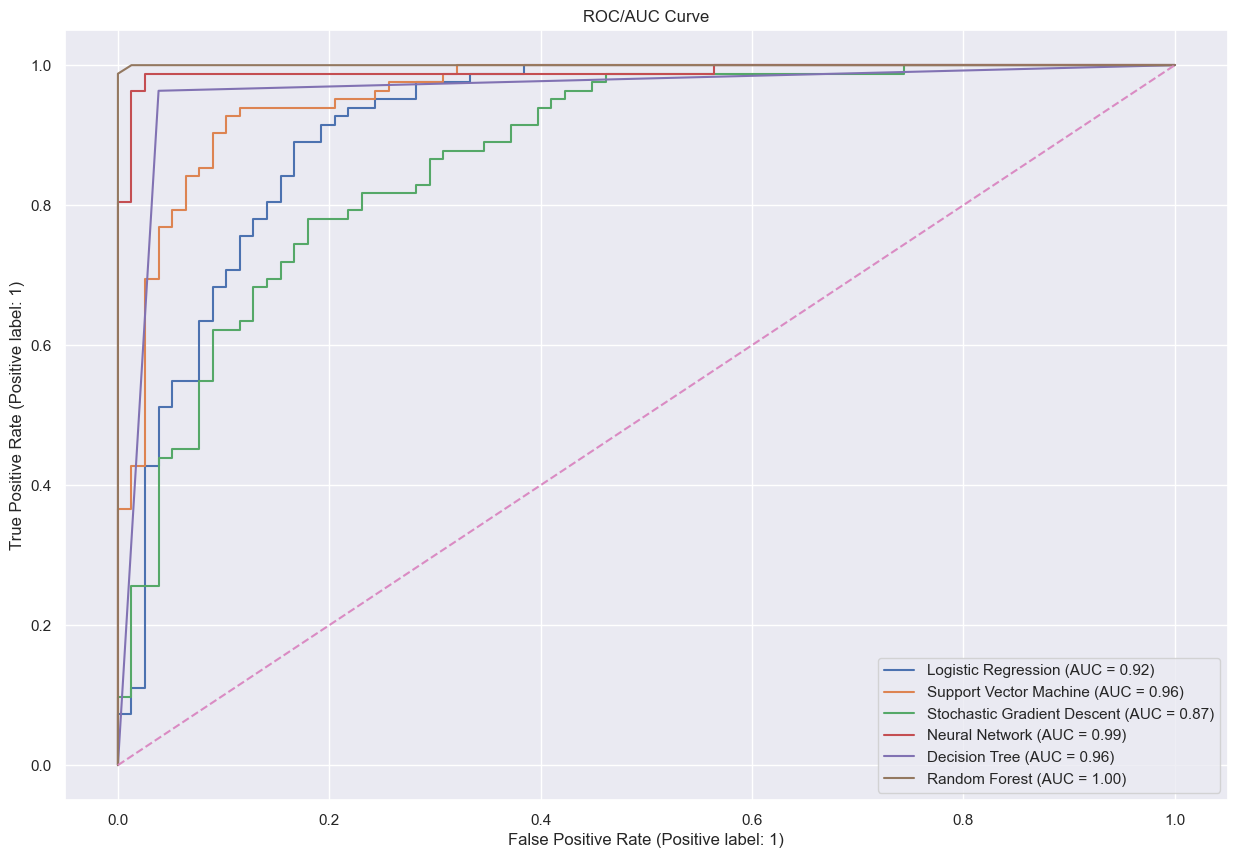

In [46]:
roc_auc(classifiers, xtrain_sfm, ytrain, xval_sfm, yval)

## Precision/Recall Curve

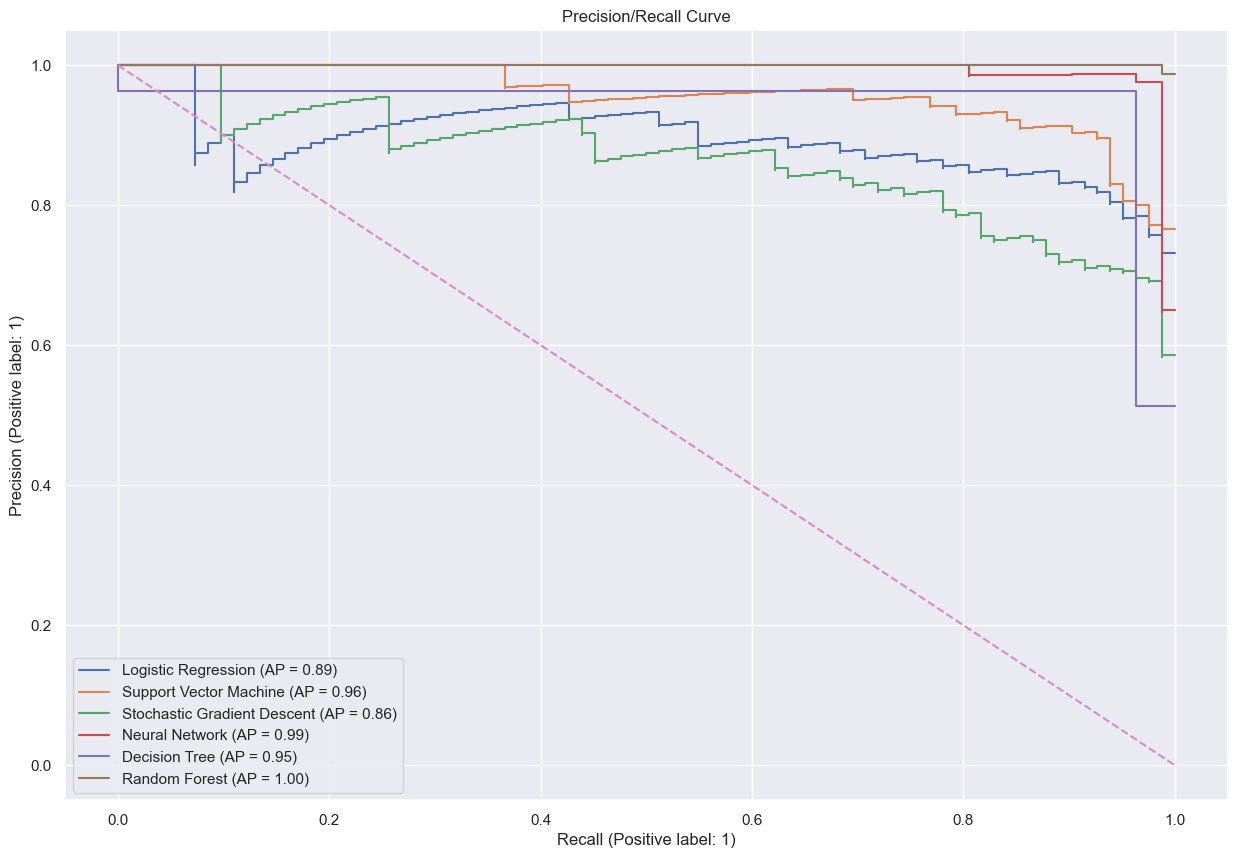

In [47]:
prec_rec(classifiers, xtrain_sfm, ytrain, xval_sfm, yval)

---
# Model Optimization


## Stochastic Gradient Descent (SGDClassifier) - Optimizing
- A description of the classifier and of the hyperparameter tuning can be find in the Annex

In [48]:
xtrain_sgd, xtrain_sgd_unscaled = encode_scale(xtrain, MinMaxScaler(feature_range=(-1,1)), reset_fit=True)

fit & transform successful...


In [49]:
xval_sgd = encode_scale(xval)

transform successful...


In [50]:
# feature selection with SelectFromModel (SGDClassifier)
sfm = SelectFromModel(SGDClassifier(random_state = 1))
sfm.fit(xtrain_sgd, ytrain)

xtrain_sfm = pd.DataFrame(sfm.transform(xtrain_sgd), columns=xtrain_sgd.columns[(sfm.get_support())], index=xtrain_sgd.index)
xval_sfm = pd.DataFrame(sfm.transform(xval_sgd), columns=xval_sgd.columns[(sfm.get_support())], index=xval_sgd.index)

xtrain_sgd_unscaled = sfm.transform(xtrain_sgd_unscaled)

In [51]:
# get first score of model
model = SGDClassifier(random_state = 1)
model.fit(xtrain_sfm, ytrain)

ypred = model.predict(xval_sfm)

print(f'F1 Score: {f1_score(yval, ypred)}')

F1 Score: 0.8250000000000001


In [52]:
# create pipeline
pipeline_sgd = Pipeline([('transformer', MinMaxScaler(feature_range=(-1,1))), ('clf',SGDClassifier(random_state=1))])

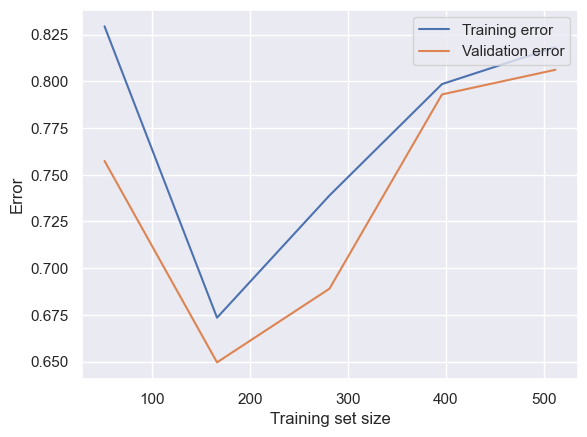

In [53]:
# checking the learning curve for over-fitting
plot_learning_curve(X=xtrain_sgd_unscaled,y=ytrain,pipeline=pipeline_sgd)

In [54]:
# performing hyperparameter tuning
param_grid = {
    'clf__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'clf__penalty': ['none', 'l2', 'l1', 'elasticnet'],
    'clf__alpha': [0.0001, 0.001, 0.01, 0.1],
    'clf__l1_ratio': [0, 0.15, 0.5, 0.85, 1]
}

rand_search = RandomizedSearchCV(pipeline_sgd, param_distributions=param_grid, cv=10, scoring = 'f1', n_jobs = -1, random_state=1)
rand_search.fit(xtrain_sgd_unscaled, ytrain)

best_parameter = {key.replace('clf__',''):value for key, value in rand_search.best_params_.items()}
print(best_parameter)

{'penalty': 'elasticnet', 'loss': 'modified_huber', 'l1_ratio': 1, 'alpha': 0.01}


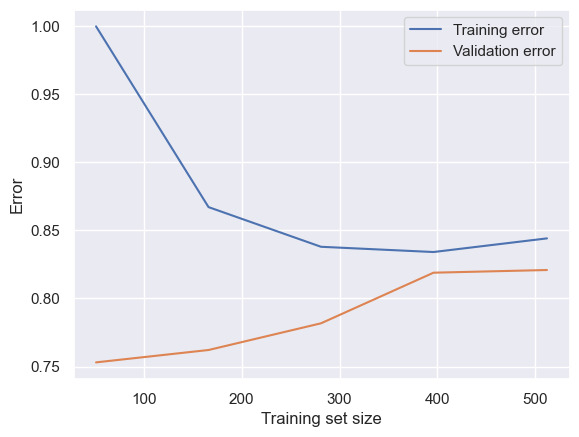

In [55]:
# check learning curve again
pipeline_sgd = Pipeline([('transformer', MinMaxScaler(feature_range=(-1,1))), ('clf',SGDClassifier(**best_parameter,random_state=1))])
plot_learning_curve(xtrain_sgd, ytrain, pipeline_sgd,)

In [56]:
# get final score with tuned hyperparameters
model = SGDClassifier(**best_parameter, random_state = 1)
model.fit(xtrain_sfm, ytrain)

ypred = model.predict(xval_sfm)

print(f'F1 Score: {f1_score(yval, ypred)}')

F1 Score: 0.8372093023255814


---
## Neural Network - Optimizing

In [57]:
xtrain_nn, xtrain_nn_unscaled = encode_scale(xtrain, MinMaxScaler(feature_range=(-1,1)), reset_fit=True)

fit & transform successful...


In [58]:
xval_nn = encode_scale(xval)

transform successful...


In [59]:
# set dataframe to columns from univariate feature selection 
xtrain_uni = xtrain_nn[univariate_features]
xval_uni = xval_nn[univariate_features]

xtrain_nn_unscaled = xtrain_nn_unscaled[univariate_features]

In [60]:
# set max_iter for executions below
m_i = 1500

In [61]:
# get first score of model
model = MLPClassifier(max_iter = m_i, random_state = 1)
model.fit(xtrain_uni, ytrain)

ypred = model.predict(xval_uni)

print(f'F1 Score: {f1_score(yval, ypred)}')

F1 Score: 0.9221556886227545


In [62]:
# create pipeline
pipeline_nn = Pipeline([('transformer', MinMaxScaler(feature_range=(-1,1))), ('clf',MLPClassifier(max_iter=m_i, random_state=1))])

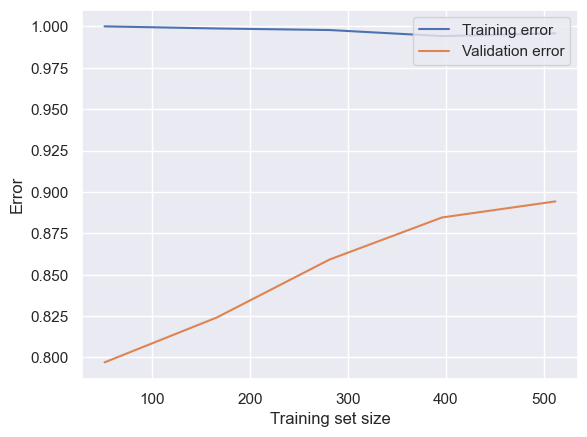

In [63]:
# checking the learning curve for over-fitting
plot_learning_curve(X=xtrain_nn_unscaled,y=ytrain,pipeline=pipeline_nn)

In [64]:
# performing hyperparameter tuning
param_grid = {
    #'clf__early_stopping': [True, False],
    #'clf__validation_fraction': [0.01, 0.1, 0.3],
    'clf__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'clf__solver': ['sgd', 'adam'],
    'clf__alpha': [ 3,5,7,8, 9, 15, 10, 20],
    #"clf__shuffle":[True, False]
    #'clf__learning_rate': ['constant', 'invscaling', 'adaptive'],
    #'clf__tol': [1e-18, 1e-17, 1e-16, 1e-15, 1e-14,0.00000001],
    #'clf__n_iter_no_change': [50, 100], 
    #"clf__warm_start": [True, False]
}

rand_search = RandomizedSearchCV(pipeline_nn, param_distributions=param_grid, cv=10, scoring = 'f1', n_jobs = -1, random_state=1)
rand_search.fit(xtrain_nn_unscaled, ytrain)

best_parameter = {key.replace('clf__',''):value for key, value in rand_search.best_params_.items()}
print(best_parameter)

{'solver': 'sgd', 'alpha': 5, 'activation': 'identity'}


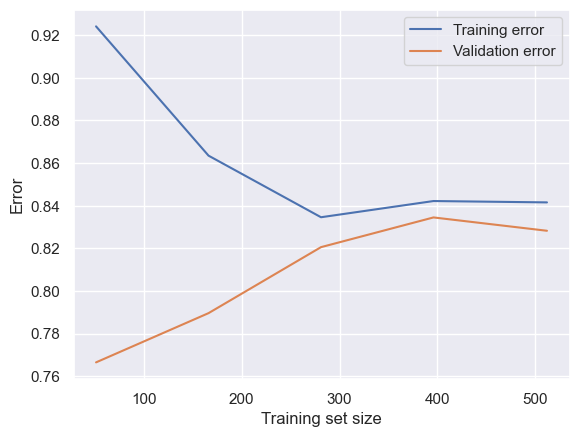

In [65]:
# check learning curve again
pipeline_nn = Pipeline([('transformer', MinMaxScaler(feature_range=(-1,1))), ('clf',MLPClassifier(**best_parameter,max_iter=m_i,random_state=1))])
plot_learning_curve(xtrain_sgd, ytrain, pipeline_nn)

In [66]:
# get final score with tuned hyperparameters
model = MLPClassifier(max_iter=m_i, **best_parameter, random_state=1)
model.fit(xtrain_uni, ytrain)

ypred = model.predict(xval_uni)

print(f'F1 Score: {f1_score(yval, ypred)}')

F1 Score: 0.8235294117647058


---
## Decision Tree - Optimizing

In [67]:
xtrain_dt, xtrain_dt_unscaled = encode_scale(xtrain, StandardScaler(), reset_fit=True)

fit & transform successful...


In [68]:
xval_dt = encode_scale(xval)

transform successful...


In [69]:
# feature selection with SelectFromModel (DecisionTreeClassifier)
sfm = SelectFromModel(DecisionTreeClassifier(random_state = 1))
sfm.fit(xtrain_dt, ytrain)

xtrain_sfm = pd.DataFrame(sfm.transform(xtrain_dt), columns=xtrain_dt.columns[(sfm.get_support())], index=xtrain_dt.index)
xval_sfm = pd.DataFrame(sfm.transform(xval_dt), columns=xval_dt.columns[(sfm.get_support())], index=xval_dt.index)

xtrain_dt_unscaled = sfm.transform(xtrain_dt_unscaled)

In [70]:
# get first score of model
model = DecisionTreeClassifier(random_state = 1)
model.fit(xtrain_sfm, ytrain)

ypred = model.predict(xval_sfm)

print(f'F1 Score: {f1_score(yval, ypred)}')

F1 Score: 0.9879518072289156


In [71]:
# create pipeline
pipeline_dt = Pipeline([('transformer', StandardScaler()), ('clf',DecisionTreeClassifier(random_state=1))])

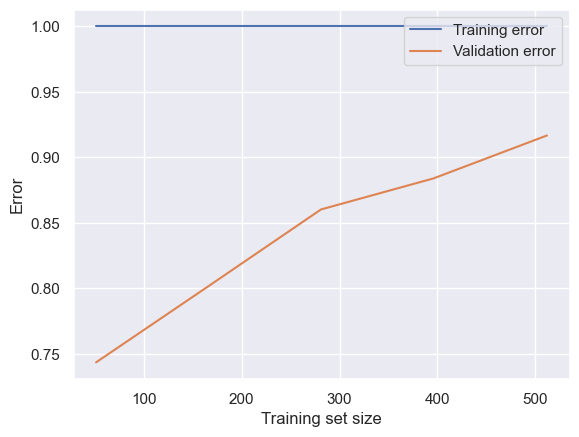

In [72]:
# checking the learning curve for over-fitting
plot_learning_curve(X=xtrain_dt_unscaled,y=ytrain,pipeline=pipeline_dt)

In [73]:
# performing hyperparameter tuning
param_grid = {
    'clf__max_depth': [5, 10, 15, 20, 25],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 3],
    'clf__max_features': ['sqrt', 'log2', None]
}

rand_search = RandomizedSearchCV(pipeline_dt, param_distributions=param_grid, cv=10, scoring = 'f1', n_jobs = -1, random_state=1)
rand_search.fit(xtrain_dt_unscaled, ytrain)

best_parameter = {key.replace('clf__',''):value for key, value in rand_search.best_params_.items()}
print(best_parameter)

{'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 25}


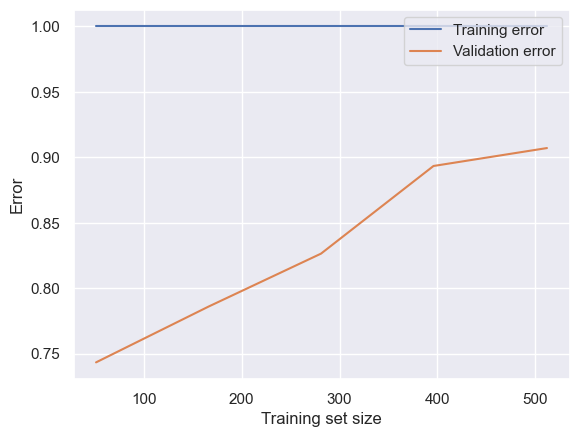

In [74]:
# check learning curve again
pipeline_dt = Pipeline([('transformer', StandardScaler()), ('clf',DecisionTreeClassifier(**best_parameter,random_state=1))])
plot_learning_curve(xtrain_dt_unscaled, ytrain, pipeline_dt)

In [75]:
# get final score with tuned hyperparameters
model = DecisionTreeClassifier(**best_parameter, random_state = 1)
model.fit(xtrain_sfm, ytrain)

ypred = model.predict(xval_sfm)

print(f'F1 Score: {f1_score(yval, ypred)}')

F1 Score: 0.9325153374233128


---
## Random Forest - Optimizing

In [76]:
xtrain_rf, xtrain_rf_unscaled = encode_scale(xtrain, StandardScaler(), reset_fit=True)

fit & transform successful...


In [77]:
xval_rf = encode_scale(xval)

transform successful...


In [78]:
# feature selection with SelectFromModel (RandomForestClassifier)
sfm = SelectFromModel(RandomForestClassifier(random_state = 1))
sfm.fit(xtrain_rf, ytrain)

xtrain_sfm = pd.DataFrame(sfm.transform(xtrain_rf), columns=xtrain_rf.columns[(sfm.get_support())], index=xtrain_rf.index)
xval_sfm = pd.DataFrame(sfm.transform(xval_rf), columns=xval_rf.columns[(sfm.get_support())], index=xval_rf.index)

xtrain_rf_unscaled = sfm.transform(xtrain_rf_unscaled)

In [79]:
# get first score of model
model = RandomForestClassifier(random_state = 1)
model.fit(xtrain_sfm, ytrain)

ypred = model.predict(xval_sfm)

print(f'F1 Score: {f1_score(yval, ypred)}')

F1 Score: 0.9938650306748467


In [80]:
# create pipeline
pipeline_rf = Pipeline([('transformer', StandardScaler()), ('clf',RandomForestClassifier(random_state=1))])

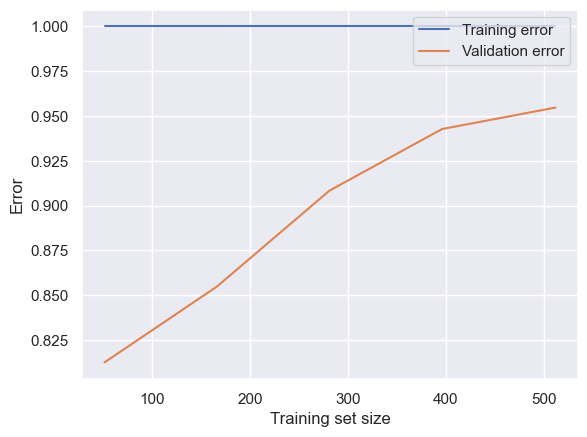

In [81]:
# checking the learning curve for over-fitting
plot_learning_curve(X=xtrain_rf_unscaled,y=ytrain,pipeline=pipeline_rf)

In [82]:
# performing hyperparameter tuning
param_grid = {
    'clf__n_estimators': [100, 200, 300, 400, 500],
    'clf__max_depth': [5, 10, 15, 20, 25],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 3],
    'clf__max_features': ['sqrt', 'log2', None]
}

rand_search = RandomizedSearchCV(pipeline_rf, param_distributions=param_grid, cv=10, scoring = 'f1', n_jobs = -1, random_state=12)
rand_search.fit(xtrain_rf_unscaled, ytrain)

best_parameter = {key.replace('clf__',''):value for key, value in rand_search.best_params_.items()}
print(best_parameter)

{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 25}


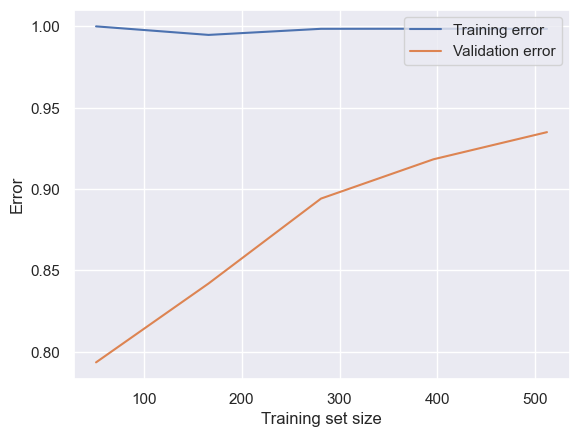

In [83]:
# check learning curve again
pipeline_rf = Pipeline([('transformer', StandardScaler()), ('clf',RandomForestClassifier(**best_parameter,random_state=1))])
plot_learning_curve(xtrain_rf_unscaled, ytrain, pipeline_rf)

In [84]:
# get final score with tuned hyperparameters
model = RandomForestClassifier(**best_parameter, random_state = 1)
model.fit(xtrain_sfm, ytrain)

ypred = model.predict(xval_sfm)

print(f'F1 score: {f1_score(yval, ypred)}')

F1 score: 0.993939393939394


---
# Submission 
- Due to the F1 Scores on the validation set and the development of the learning curve we chose the random forest as our classifier 
- Next we prepare the full training and the test set and predict the values with the variables and parameters found in the feature- and model-selection process

**1** - Train on full dataset

In [85]:
# apply encoding & scaling
# reset_fit set to True for new fit_transform (including all train observations)
xtrain_prepro_full = encode_scale(preprocessing(x), scaler = StandardScaler(), reset_fit = True)[0]

fit & transform successful...


In [86]:
# apply feature selection on full train dataset
xtrain_sfm_full = sfm.transform(xtrain_prepro_full)

In [87]:
# fit model with best hyperparameters
model = RandomForestClassifier(**best_parameter, random_state = 1)
model.fit(xtrain_sfm_full, y)

RandomForestClassifier(max_depth=25, max_features=None, min_samples_split=5,
                       n_estimators=500, random_state=1)

**2** - Prepare test dataset and predict

In [88]:
# apply preprocessing function and encode_scale function to test dataset
xtest_prepro = encode_scale(preprocessing(df_test))

transform successful...


In [89]:
# transform data to SelectFromModel
xtest_sfm = sfm.transform(xtest_prepro)

In [90]:
# final predict
ypred = model.predict(xtest_sfm)

In [91]:
df_submission = pd.concat([pd.Series(df_test.index),pd.Series(ypred)], axis = 1)
df_submission.rename(columns = {0:'Disease'}, inplace = True)
df_submission

,PatientID,Disease
0,1343,1
1,1727,1
2,1828,1
3,1155,1
4,1020,0
...,...,...
220,1000,0
221,1256,1
222,1318,0
223,1953,1


In [93]:
df_submission.to_csv('Group01_Final_RandomForest.csv', index = False)